In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import re
import scanpy as sc
from scipy.sparse import csr_matrix
import scvi
import torch
import seaborn as sns

In [3]:
filename = '../data_out/matrix_filtered_stim_after_filtering.h5ad'
adata_stim = sc.read(filename)

In [4]:
filename = '../data_out/matrix_filtered_nostim_after_filtering.h5ad'
adata_nostim = sc.read(filename)

In [5]:
adata = sc.concat([adata_stim, adata_nostim])

In [6]:
df_guide_target = pd.read_csv('../data/Perturb-seq/data/guide-target-categories.txt', sep='\t')
adata.obs = adata.obs.merge(df_guide_target, on='gene', how='left')

In [7]:
sc.pp.filter_genes(adata, min_cells = 10)

/home/julian/miniconda3/envs/cellrep/lib/python3.12/site-packages/anndata/_core/aligned_df.py:68: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


In [8]:
type(adata.X)

scipy.sparse._csr.csr_matrix

In [9]:
adata.write_h5ad('../data_out/matrix_combined.h5ad')

In [10]:
sc.pp.filter_genes(adata, min_cells = 400)

In [11]:
adata.layers['counts'] = adata.X.copy()

In [12]:
sc.pp.normalize_total(adata, target_sum = 1e4)
sc.pp.log1p(adata)
adata.raw = adata

In [13]:
torch.set_float32_matmul_precision('medium')
scvi.settings.dl_num_workers = 19
scvi.settings.batch_size = 512


scvi.model.SCVI.setup_anndata(
    adata, layer = "counts",
    categorical_covariate_keys=["condition"],
    continuous_covariate_keys=['pct_counts_mt', 'total_counts', 'pct_counts_ribo']
)

model = scvi.model.SCVI(adata)
model.to_device('cuda')
model.train(batch_size=512)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Training:   0%|          | 0/153 [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=153` reached.


In [14]:
adata.obsm['X_scVI'] = model.get_latent_representation()
adata.layers['scvi_normalized'] = model.get_normalized_expression(library_size = 1e4)
sc.pp.neighbors(adata, use_rep = 'X_scVI')

In [17]:
adata.layers['scvi_normalized'].shape

(52188, 12539)

In [18]:
sc.tl.umap(adata)
sc.tl.leiden(adata, resolution = 0.8)

/tmp/ipykernel_2014680/1166341244.py:2: FutureWarning: In the future, the default backend for leiden will be igraph instead of leidenalg.

 To achieve the future defaults please pass: flavor="igraph" and n_iterations=2.  directed must also be False to work with igraph's implementation.
  sc.tl.leiden(adata, resolution = 0.8)


In [19]:
adata

AnnData object with n_obs × n_vars = 52188 × 12539
    obs: 'condition', 'crispr', 'guide_id', 'gene', 'well', 'doublet', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'n_genes', 'gene_category', 'gene_functional_category', 'notes', '_scvi_batch', '_scvi_labels', 'leiden'
    var: 'n_cells'
    uns: 'log1p', '_scvi_uuid', '_scvi_manager_uuid', 'neighbors', 'umap', 'leiden'
    obsm: '_scvi_extra_categorical_covs', '_scvi_extra_continuous_covs', 'X_scVI', 'X_umap'
    layers: 'counts', 'scvi_normalized'
    obsp: 'distances', 'connectivities'

In [20]:
adata.obs

condition     crispr    guide_id      gene well  doublet  \
0          Stim  perturbed   CEACAM1-1   CEACAM1    5    False   
1          Stim  perturbed      DEF6-1      DEF6    5    False   
2          Stim  perturbed      LCP2-2      LCP2    5    False   
3          Stim  perturbed      DEF6-1      DEF6    5    False   
4          Stim  perturbed     FOXD2-2     FOXD2    5    False   
...         ...        ...         ...       ...  ...      ...   
52183    Nostim  perturbed      CBY1-2      CBY1    4    False   
52184    Nostim  perturbed       WT1-1       WT1    4    False   
52185    Nostim  perturbed  TNFRSF1A-2  TNFRSF1A    4    False   
52186    Nostim  perturbed      EMP3-2      EMP3    4    False   
52187    Nostim  perturbed  TNFRSF1A-2  TNFRSF1A    4    False   

       n_genes_by_counts  total_counts  total_counts_mt  pct_counts_mt  \
0                   1506        3263.0            723.0      22.157522   
1                   2980        6823.0            807.0      11.827641   
2                   2611        7027.0            373.0       5.308097   
3                   3025        6902.0           1003.0      14.532020   
4                   3613       10561.0           2070.0      19.600416   
...                  ...           ...              ...            ...   
52183                830        1381.0            198.0      14.337437   
52184               2782        7064.0            530.0       7.502831   
52185               3649       10544.0            925.0       8.772762   
52186               1734        3778.0            332.0       8.787719   
52187               2382        5793.0            281.0       4.850682   

       total_counts_ribo  pct_counts_ribo  n_genes       gene_category  \
0                  361.0        11.063438     1506       Negative_Both   
1                  743.0        10.889638     2980       Positive_Both   
2                 1097.0        15.611214     2611       Positive_Both   
3                  648.0         9.388583     3025       Positive_Both   
4                 1024.0         9.696052     3613       Positive_Both   
...                  ...              ...      ...                 ...   
52183              137.0         9.920347      830   Positive_IL2_only   
52184              716.0        10.135900     2782  Positive_IFNg_only   
52185              771.0         7.312215     3649       Positive_Both   
52186              702.0        18.581259     1734       Positive_Both   
52187              420.0         7.250129     2382       Positive_Both   

        gene_functional_category          notes  _scvi_batch  _scvi_labels  \
0             Negative Regulator            NaN            0             0   
1               GTPase signaling            NaN            0             0   
2               TCR Stim/Co-Stim            NaN            0             0   
3               GTPase signaling            NaN            0             0   
4           Transcription Factor            NaN            0             0   
...                          ...            ...          ...           ...   
52183  Other Signal Transduction  Wnt signaling            0             0   
52184       Transcription Factor            NaN            0             0   
52185   TNF receptor superfamily            NaN            0             0   
52186            Other / Unknown            NaN            0             0   
52187   TNF receptor superfamily            NaN            0             0   

      leiden  
0          7  
1          0  
2          0  
3          0  
4          0  
...      ...  
52183      2  
52184      5  
52185     10  
52186      2  
52187     10  

[52188 rows x 19 columns]

In [33]:
adata.obs['']

condition     crispr    guide_id      gene well  doublet  \
0          Stim  perturbed   CEACAM1-1   CEACAM1    5    False   
1          Stim  perturbed      DEF6-1      DEF6    5    False   
2          Stim  perturbed      LCP2-2      LCP2    5    False   
3          Stim  perturbed      DEF6-1      DEF6    5    False   
4          Stim  perturbed     FOXD2-2     FOXD2    5    False   
...         ...        ...         ...       ...  ...      ...   
52183    Nostim  perturbed      CBY1-2      CBY1    4    False   
52184    Nostim  perturbed       WT1-1       WT1    4    False   
52185    Nostim  perturbed  TNFRSF1A-2  TNFRSF1A    4    False   
52186    Nostim  perturbed      EMP3-2      EMP3    4    False   
52187    Nostim  perturbed  TNFRSF1A-2  TNFRSF1A    4    False   

       n_genes_by_counts  total_counts  total_counts_mt  pct_counts_mt  \
0                   1506        3263.0            723.0      22.157522   
1                   2980        6823.0            807.0      11.827641   
2                   2611        7027.0            373.0       5.308097   
3                   3025        6902.0           1003.0      14.532020   
4                   3613       10561.0           2070.0      19.600416   
...                  ...           ...              ...            ...   
52183                830        1381.0            198.0      14.337437   
52184               2782        7064.0            530.0       7.502831   
52185               3649       10544.0            925.0       8.772762   
52186               1734        3778.0            332.0       8.787719   
52187               2382        5793.0            281.0       4.850682   

       total_counts_ribo  pct_counts_ribo  n_genes       gene_category  \
0                  361.0        11.063438     1506       Negative_Both   
1                  743.0        10.889638     2980       Positive_Both   
2                 1097.0        15.611214     2611       Positive_Both   
3                  648.0         9.388583     3025       Positive_Both   
4                 1024.0         9.696052     3613       Positive_Both   
...                  ...              ...      ...                 ...   
52183              137.0         9.920347      830   Positive_IL2_only   
52184              716.0        10.135900     2782  Positive_IFNg_only   
52185              771.0         7.312215     3649       Positive_Both   
52186              702.0        18.581259     1734       Positive_Both   
52187              420.0         7.250129     2382       Positive_Both   

        gene_functional_category          notes  _scvi_batch  _scvi_labels  \
0             Negative Regulator            NaN            0             0   
1               GTPase signaling            NaN            0             0   
2               TCR Stim/Co-Stim            NaN            0             0   
3               GTPase signaling            NaN            0             0   
4           Transcription Factor            NaN            0             0   
...                          ...            ...          ...           ...   
52183  Other Signal Transduction  Wnt signaling            0             0   
52184       Transcription Factor            NaN            0             0   
52185   TNF receptor superfamily            NaN            0             0   
52186            Other / Unknown            NaN            0             0   
52187   TNF receptor superfamily            NaN            0             0   

      leiden  _scvi_raw_norm_scaling  
0          7                3.081664  
1          0                1.469508  
2          0                1.424704  
3          0                1.452855  
4          0                0.949397  
...      ...                     ...  
52183      2                7.278020  
52184      5                1.420051  
52185     10                0.950480  
52186      2                2.651816  
52187     10                1.730403  

[52188 rows x 20 columns]

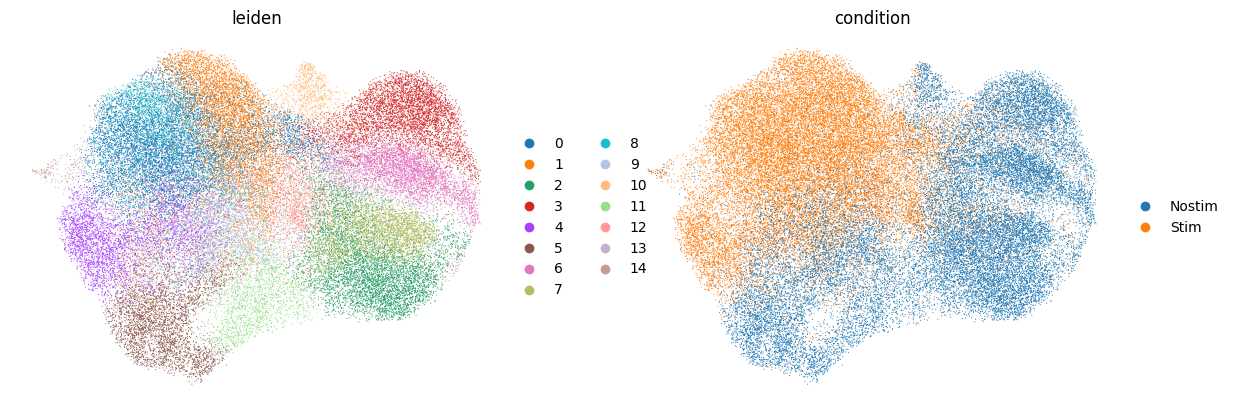

In [35]:
sc.pl.umap(adata, color = ['leiden', 'condition'], frameon = False)

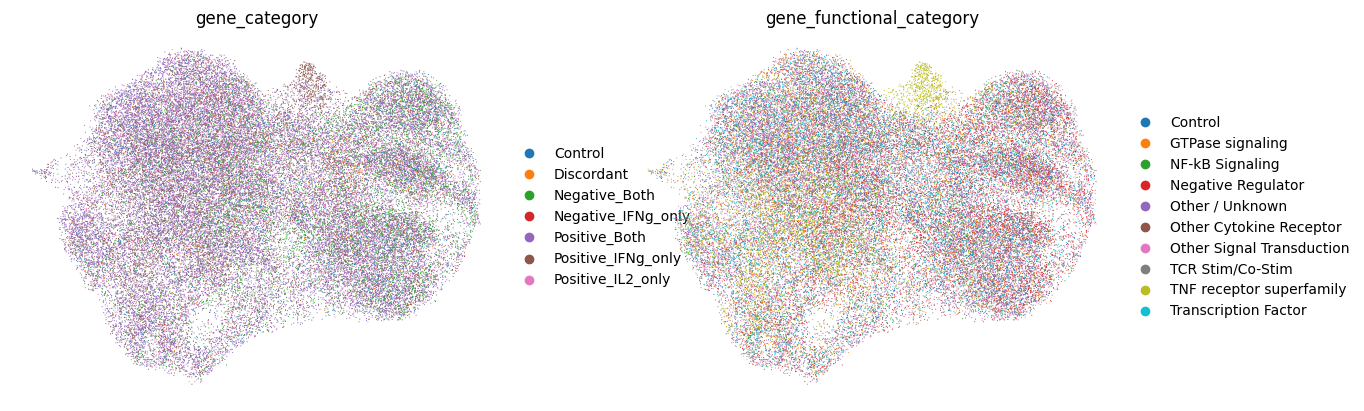

In [39]:
sc.pl.umap(adata[~adata.obs['gene_category'].isna()], color = ['gene_category', 'gene_functional_category'], frameon = False)

In [22]:
adata.write_h5ad('../data_out/integrated.h5ad')

In [23]:
adata

AnnData object with n_obs × n_vars = 52188 × 12539
    obs: 'condition', 'crispr', 'guide_id', 'gene', 'well', 'doublet', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'n_genes', 'gene_category', 'gene_functional_category', 'notes', '_scvi_batch', '_scvi_labels', 'leiden'
    var: 'n_cells'
    uns: 'log1p', '_scvi_uuid', '_scvi_manager_uuid', 'neighbors', 'umap', 'leiden', 'leiden_colors', 'condition_colors', 'gene_colors'
    obsm: '_scvi_extra_categorical_covs', '_scvi_extra_continuous_covs', 'X_scVI', 'X_umap'
    layers: 'counts', 'scvi_normalized'
    obsp: 'distances', 'connectivities'

In [24]:
sc.tl.rank_genes_groups(adata, 'leiden')

In [63]:
# sc.pl.rank_genes_groups(adata, n_genes=20, sharey=False)

In [25]:
markers = sc.get.rank_genes_groups_df(adata, None)
markers = markers[(markers.pvals < 0.05) & markers.logfoldchanges > 0.5]
markers

group       names      scores  logfoldchanges  pvals  pvals_adj
0          0        GZMB  171.288742        4.447806    0.0        0.0
1          0       IL2RA  141.164871        2.563680    0.0        0.0
2          0         PKM  135.727341        1.616570    0.0        0.0
3          0    HSP90AB1  135.273544        1.631898    0.0        0.0
4          0        ENO1  117.577744        1.191741    0.0        0.0
...      ...         ...         ...             ...    ...        ...
188080    14  AC119673.2  -42.075951      -25.056978    0.0        0.0
188081    14       CLIC3  -43.346989      -25.404181    0.0        0.0
188082    14       EGLN3  -47.795250      -25.706364    0.0        0.0
188083    14      FCER1G  -50.178436      -25.967348    0.0        0.0
188084    14      SCARB2  -61.151573      -26.147673    0.0        0.0

[130340 rows x 6 columns]

In [26]:
markers_scvi = model.differential_expression(groupby='leiden')

DE...:   0%|          | 0/15 [00:00<?, ?it/s]

In [27]:
markers_scvi

proba_de  proba_not_de  bayes_factor    scale1    scale2  \
CCL3        0.9752        0.0248      3.671799  0.001336  0.000309   
CCL4        0.9718        0.0282      3.539828  0.002170  0.000315   
GZMB        0.9678        0.0322      3.403059  0.004645  0.000908   
IL5         0.9654        0.0346      3.328689  0.000032  0.000048   
SOX2        0.9630        0.0370      3.259135  0.000087  0.000019   
...            ...           ...           ...       ...       ...   
TUBGCP2     0.3282        0.6718     -0.716337  0.000064  0.000068   
SAR1A       0.3196        0.6804     -0.755611  0.000075  0.000073   
PPHLN1      0.3012        0.6988     -0.841590  0.000101  0.000093   
PAFAH1B1    0.2468        0.7532     -1.115752  0.000165  0.000171   
AP2M1       0.2464        0.7536     -1.117905  0.000135  0.000140   

          pseudocounts  delta  lfc_mean  lfc_median   lfc_std  ...  raw_mean1  \
CCL3               0.0   0.25  3.800201    4.200615  3.491421  ...  12.623937   
CCL4               0.0   0.25  3.465603    3.638955  3.030315  ...  25.119720   
GZMB               0.0   0.25  4.271538    4.394099  3.022932  ...  44.815025   
IL5                0.0   0.25  1.822228    2.054715  3.534245  ...   0.016862   
SOX2               0.0   0.25  3.323367    3.516974  2.261718  ...   0.115893   
...                ...    ...       ...         ...       ...  ...        ...   
TUBGCP2            0.0   0.25 -0.096324   -0.097918  0.227269  ...   0.182724   
SAR1A              0.0   0.25  0.039137    0.036107  0.256106  ...   0.295681   
PPHLN1             0.0   0.25  0.118814    0.126121  0.195544  ...   0.395349   
PAFAH1B1           0.0   0.25 -0.046367   -0.039480  0.213403  ...   0.614618   
AP2M1              0.0   0.25 -0.049081   -0.040984  0.212620  ...   0.441861   

          raw_mean2  non_zeros_proportion1  non_zeros_proportion2  \
CCL3       3.752542               0.631937               0.217468   
CCL4       4.379645               0.648043               0.212699   
GZMB       8.535758               0.966025               0.434009   
IL5        0.211139               0.008934               0.011550   
SOX2       0.023869               0.049956               0.010352   
...             ...                    ...                    ...   
TUBGCP2    0.467637               0.142857               0.349240   
SAR1A      0.497922               0.179402               0.365082   
PPHLN1     0.661980               0.239203               0.457224   
PAFAH1B1   1.177627               0.302326               0.640661   
AP2M1      0.966183               0.242525               0.571569   

          raw_normalized_mean1  raw_normalized_mean2  is_de_fdr_0.05  \
CCL3                 17.386042              4.379039            True   
CCL4                 36.915985              5.162462            True   
GZMB                 64.123039             10.765527            True   
IL5                   0.023608              0.222904            True   
SOX2                  0.172995              0.029552            True   
...                        ...                   ...             ...   
TUBGCP2               0.622970              0.696476           False   
SAR1A                 0.683109              0.717786           False   
PPHLN1                1.152674              0.986675           False   
PAFAH1B1              1.617258              1.745575           False   
AP2M1                 0.929866              1.406194           False   

          comparison  group1 group2  
CCL3       0 vs Rest       0   Rest  
CCL4       0 vs Rest       0   Rest  
GZMB       0 vs Rest       0   Rest  
IL5        0 vs Rest       0   Rest  
SOX2       0 vs Rest       0   Rest  
...              ...     ...    ...  
TUBGCP2   14 vs Rest      14   Rest  
SAR1A     14 vs Rest      14   Rest  
PPHLN1    14 vs Rest      14   Rest  
PAFAH1B1  14 vs Rest      14   Rest  
AP2M1     14 vs Rest      14   Rest  

[188085 rows x 22 columns]

In [28]:
markers_scvi_filtered = markers_scvi[(markers_scvi['is_de_fdr_0.05'] < 0.05) & (markers_scvi.lfc_mean > 0.5)]

In [29]:
markers_scvi_filtered

proba_de  proba_not_de  bayes_factor    scale1    scale2  \
PBK         0.9404        0.0596      2.758650  0.000023  0.000027   
POU2AF1     0.9398        0.0602      2.747995  0.000017  0.000006   
CDC25A      0.9394        0.0606      2.740946  0.000029  0.000012   
CSF1        0.9390        0.0610      2.733941  0.000132  0.000040   
ERRFI1      0.9390        0.0610      2.733941  0.000037  0.000012   
...            ...           ...           ...       ...       ...   
WARS2       0.7448        0.2552      1.071068  0.000025  0.000017   
C17orf80    0.7444        0.2556      1.068965  0.000047  0.000032   
SNAPC2      0.7420        0.2580      1.056390  0.000019  0.000013   
ZNF275      0.7418        0.2582      1.055345  0.000022  0.000015   
SRFBP1      0.7400        0.2600      1.045969  0.000078  0.000055   

          pseudocounts  delta  lfc_mean  lfc_median   lfc_std  ...  raw_mean1  \
PBK                0.0   0.25  0.599066    0.750620  2.721009  ...   0.153014   
POU2AF1            0.0   0.25  1.790754    1.864960  1.890896  ...   0.121681   
CDC25A             0.0   0.25  1.909936    1.923564  2.431825  ...   0.241604   
CSF1               0.0   0.25  2.046050    2.133413  1.687408  ...   0.891017   
ERRFI1             0.0   0.25  1.879469    1.919729  1.922127  ...   0.030200   
...                ...    ...       ...         ...       ...  ...        ...   
WARS2              0.0   0.25  0.527696    0.528567  0.557024  ...   0.076412   
C17orf80           0.0   0.25  0.528222    0.515440  0.527109  ...   0.142857   
SNAPC2             0.0   0.25  0.536698    0.521532  0.541816  ...   0.089701   
ZNF275             0.0   0.25  0.545287    0.493016  0.627016  ...   0.053156   
SRFBP1             0.0   0.25  0.540269    0.451828  0.694805  ...   0.239203   

          raw_mean2  non_zeros_proportion1  non_zeros_proportion2  \
PBK        0.228803               0.117025               0.147578   
POU2AF1    0.048101               0.091984               0.038788   
CDC25A     0.113451               0.191770               0.094482   
CSF1       0.239787               0.385680               0.152415   
ERRFI1     0.008974               0.015352               0.006442   
...             ...                    ...                    ...   
WARS2      0.105538               0.069767               0.095766   
C17orf80   0.209422               0.122924               0.179737   
SNAPC2     0.094282               0.069767               0.088712   
ZNF275     0.094186               0.046512               0.086496   
SRFBP1     0.352295               0.136213               0.270280   

          raw_normalized_mean1  raw_normalized_mean2  is_de_fdr_0.05  \
PBK                   0.164851              0.224690           False   
POU2AF1               0.174706              0.061657           False   
CDC25A                0.302222              0.126456           False   
CSF1                  1.415407              0.385048           False   
ERRFI1                0.038344              0.013544           False   
...                        ...                   ...             ...   
WARS2                 0.161825              0.152079           False   
C17orf80              0.498130              0.314688           False   
SNAPC2                0.238111              0.139625           False   
ZNF275                0.189603              0.144835           False   
SRFBP1                0.594778              0.516923           False   

          comparison  group1 group2  
PBK        0 vs Rest       0   Rest  
POU2AF1    0 vs Rest       0   Rest  
CDC25A     0 vs Rest       0   Rest  
CSF1       0 vs Rest       0   Rest  
ERRFI1     0 vs Rest       0   Rest  
...              ...     ...    ...  
WARS2     14 vs Rest      14   Rest  
C17orf80  14 vs Rest      14   Rest  
SNAPC2    14 vs Rest      14   Rest  
ZNF275    14 vs Rest      14   Rest  
SRFBP1    14 vs Rest      14   Rest  

[25896 rows x 22 columns]

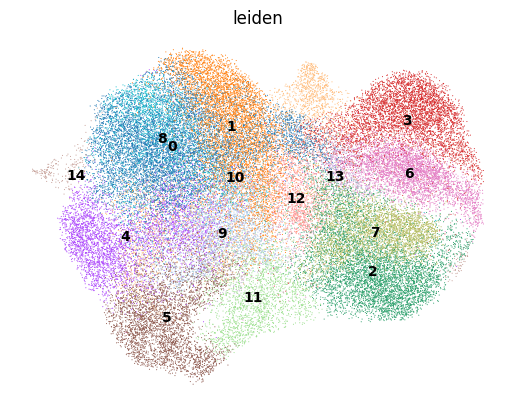

In [30]:
sc.pl.umap(adata, color = ['leiden'], frameon = False, legend_loc = "on data")

pangodb: https://panglaodb.se/markers.html?cell_type=%27choose%27

In [103]:
import numpy as np
adata.obs['TNF'] = np.array(adata[:, adata.var.index == 'TNF'].X.todense())

In [104]:
adata.obs[adata.obs['condition'] == 'Stim'].sort_values('TNF').dropna(subset=['guide_id']).groupby('gene').agg(
    TNF_mean=('TNF', 'mean'), TNF_sum=('TNF', 'sum'), guide_id=('guide_id', set), well=('well', set), 
).sort_values('TNF_mean', ascending=False)

/tmp/ipykernel_2014680/566738220.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  adata.obs[adata.obs['condition'] == 'Stim'].sort_values('TNF').dropna(subset=['guide_id']).groupby('gene').agg(


TNF_mean     TNF_sum              guide_id          well
gene                                                            
TBX21   0.638161  222.080017    {TBX21-2, TBX21-1}  {5, 7, 6, 8}
FOXQ1   0.575863  114.020882    {FOXQ1-2, FOXQ1-1}  {5, 7, 6, 8}
VAV1    0.562784  222.862381      {VAV1-1, VAV1-2}  {5, 7, 6, 8}
IL1R1   0.533283  206.380692    {IL1R1-2, IL1R1-1}  {5, 7, 6, 8}
EOMES   0.526861   43.729481    {EOMES-2, EOMES-1}  {5, 7, 6, 8}
...          ...         ...                   ...           ...
INPPL1  0.148086   38.650345  {INPPL1-1, INPPL1-2}  {5, 7, 6, 8}
SLA2    0.132427   46.746639      {SLA2-1, SLA2-2}  {5, 7, 6, 8}
MUC1    0.125536   62.391323      {MUC1-2, MUC1-1}  {5, 7, 6, 8}
MAP4K1  0.121164   41.922607  {MAP4K1-2, MAP4K1-1}  {5, 7, 6, 8}
PRDM1   0.058024    0.580243    {PRDM1-1, PRDM1-2}  {5, 7, 6, 8}

[74 rows x 4 columns]

In [88]:
import numpy as np
indexes = np.argsort(np.array(adata[:, adata.var.index == 'TNF'].X.todense().reshape(-1))).reshape(-1)
indexes

array([    0, 34381, 34382, ..., 26554, 24640,  9222])

In [89]:
adata.obs.iloc[indexes]

condition     crispr     guide_id       gene well  doublet  \
0          Stim  perturbed    CEACAM1-1    CEACAM1    5    False   
34381    Nostim  perturbed    PIK3AP1-2    PIK3AP1    2    False   
34382    Nostim  perturbed     OTUD7B-1     OTUD7B    2    False   
34383    Nostim         NT  NO-TARGET-3  NO-TARGET    2    False   
34384    Nostim  perturbed        LAT-1        LAT    2    False   
...         ...        ...          ...        ...  ...      ...   
6418       Stim  perturbed       EMP1-2       EMP1    5    False   
18403      Stim  perturbed       VAV1-2       VAV1    7    False   
26554    Nostim  perturbed     BICDL2-2     BICDL2    1    False   
24640      Stim  perturbed      NLRC3-2      NLRC3    8    False   
9222       Stim  perturbed      IL2RB-2      IL2RB    6    False   

       n_genes_by_counts  total_counts  total_counts_mt  pct_counts_mt  \
0                   1506        3263.0            723.0      22.157522   
34381               4636       17275.0           1506.0       8.717800   
34382               2331        5048.0            346.0       6.854199   
34383               2077        4409.0            402.0       9.117714   
34384               2228        4843.0            361.0       7.454057   
...                  ...           ...              ...            ...   
6418                1867        3889.0            215.0       5.528413   
18403               3328       11591.0            658.0       5.676818   
26554               2040        4884.0            584.0      11.957412   
24640               2643        7534.0            581.0       7.711707   
9222                2131        6235.0            402.0       6.447474   

       total_counts_ribo  pct_counts_ribo  n_genes       gene_category  \
0                  361.0        11.063438     1506       Negative_Both   
34381             1628.0         9.424024     4636       Positive_Both   
34382              734.0        14.540412     2331       Positive_Both   
34383              711.0        16.126104     2077             Control   
34384              733.0        15.135246     2228       Positive_Both   
...                  ...              ...      ...                 ...   
6418               562.0        14.451015     1867       Positive_Both   
18403             1645.0        14.192046     3328       Positive_Both   
26554              786.0        16.093367     2040  Positive_IFNg_only   
24640             1111.0        14.746483     2642       Positive_Both   
9222               636.0        10.200481     2131          Discordant   

        gene_functional_category               notes  _scvi_batch  \
0             Negative Regulator                 NaN            0   
34381  Other Signal Transduction                 NaN            0   
34382           TCR Stim/Co-Stim                 NaN            0   
34383                    Control                 NaN            0   
34384           TCR Stim/Co-Stim                 NaN            0   
...                          ...                 ...          ...   
6418             Other / Unknown                 NaN            0   
18403           GTPase signaling                 NaN            0   
26554            Other / Unknown   Protein transport            0   
24640  Other Signal Transduction  May regulate NF-kB            0   
9222     Other Cytokine Receptor                 NaN            0   

       _scvi_labels leiden  _scvi_raw_norm_scaling  
0                 0      7                3.081664  
34381             0      5                0.580181  
34382             0      2                1.994416  
34383             0      6                2.276349  
34384             0      6                2.071680  
...             ...    ...                     ...  
6418              0      0                2.575328  
18403             0      0                0.863856  
26554             0      2                2.061430  
24640             0      0                1.329610  

In [107]:
adata[:, adata.var.index == 'TNF']

View of AnnData object with n_obs × n_vars = 52188 × 1
    obs: 'condition', 'crispr', 'guide_id', 'gene', 'well', 'doublet', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'n_genes', 'gene_category', 'gene_functional_category', 'notes', '_scvi_batch', '_scvi_labels', 'leiden', '_scvi_raw_norm_scaling', 'TNF'
    var: 'n_cells'
    uns: 'log1p', '_scvi_uuid', '_scvi_manager_uuid', 'neighbors', 'umap', 'leiden', 'leiden_colors', 'condition_colors', 'gene_colors', 'rank_genes_groups', 'gene_category_colors', 'gene_functional_category_colors'
    obsm: '_scvi_extra_categorical_covs', '_scvi_extra_continuous_covs', 'X_scVI', 'X_umap'
    layers: 'counts', 'scvi_normalized'
    obsp: 'distances', 'connectivities'

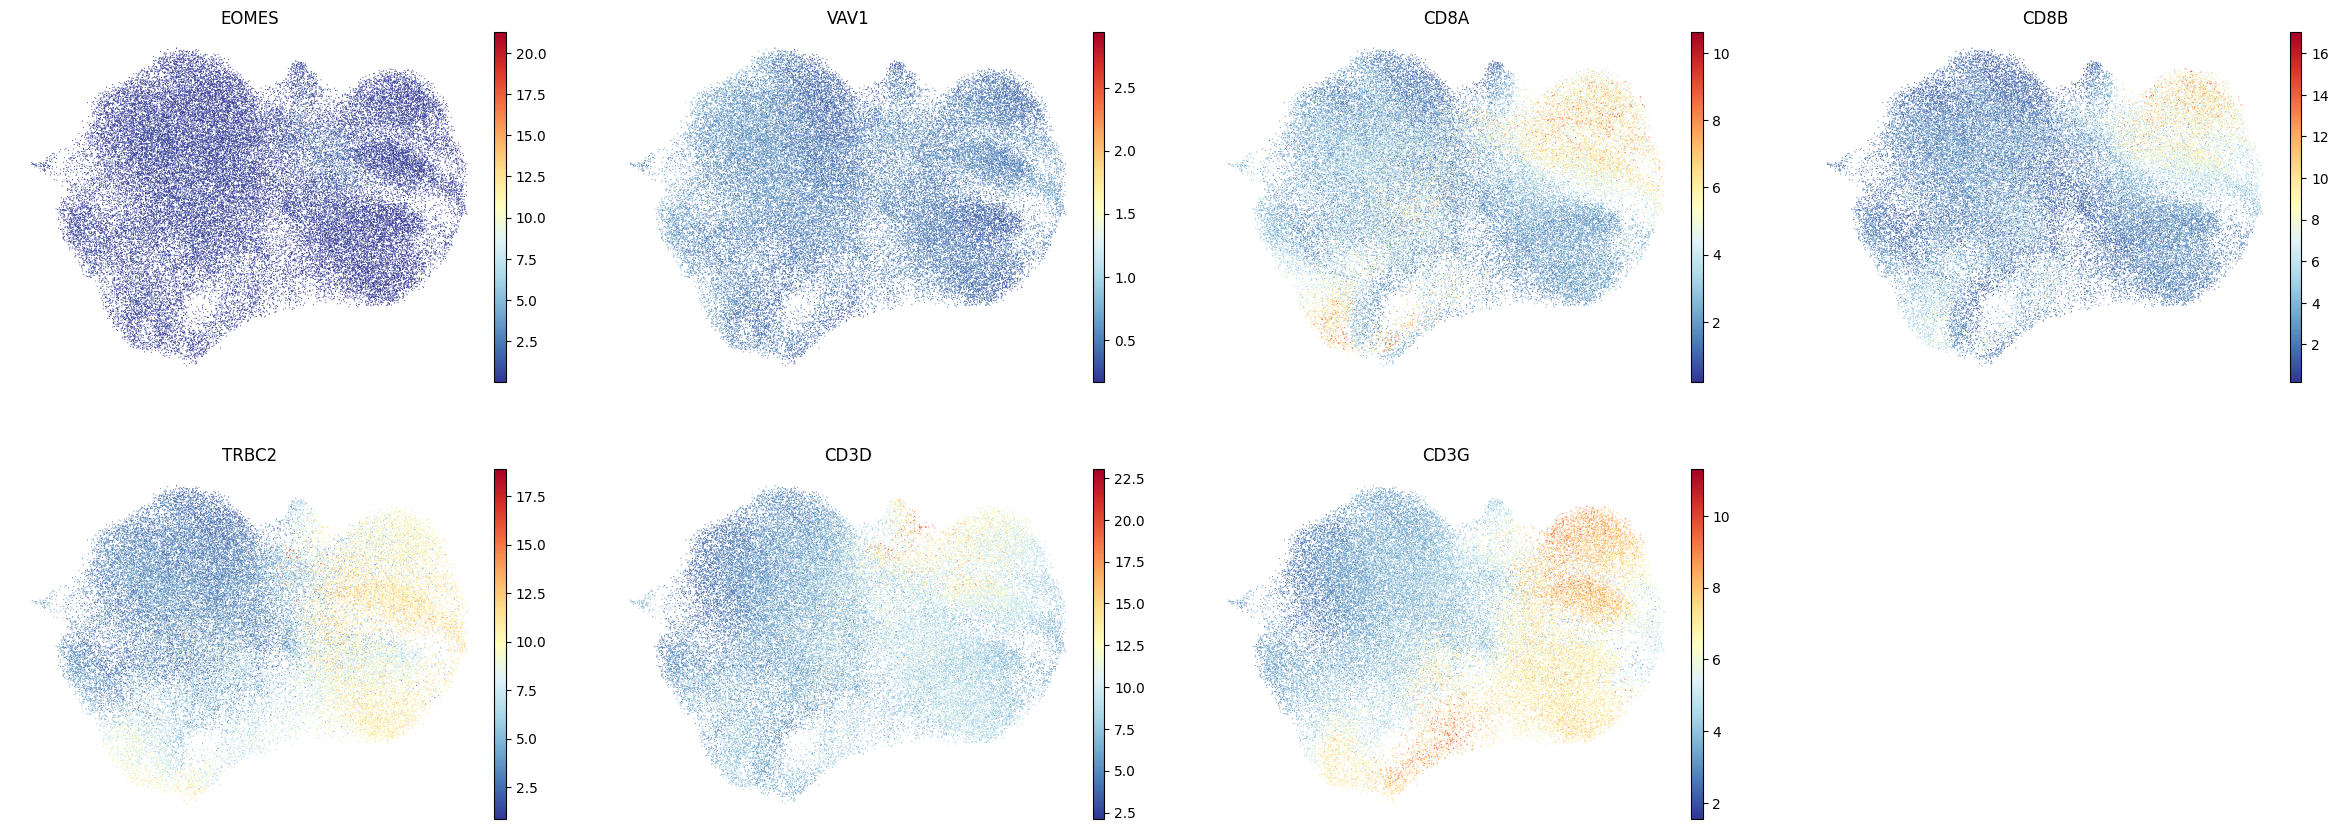

In [114]:
import matplotlib as mpl
# Que guided-genes activan el TNF
sc.pl.umap(
    adata,
    color=['EOMES', 'VAV1', 'CD8A', 'CD8B', 'TRBC2', 'CD3D', 'CD3G', 
        #    'CD3E', 'IL7R', 'LTB', 'LEF1', 'ADTRP', 'TRAC'
    ],
    # color=['CCL4', 'CCL3', 'IFNG', 'CCL4L2'],
    frameon = False,
    layer='scvi_normalized',
    palette="Set2", color_map=mpl.cm.RdYlBu_r
)

In [71]:
{
    "5": "CD8B"
}

{'5': 'CD8B'}

In [119]:
markers[['logfoldchanges', 'group']][markers.names.isin([
    'EOMES', 
    'TBX21'
])].groupby('group').sum().sort_values('logfoldchanges', ascending=False)

/tmp/ipykernel_2014680/402522277.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  ])].groupby('group').sum().sort_values('logfoldchanges', ascending=False)


logfoldchanges
group                
13           3.719554
0            2.218986
4            1.072200
9            0.530035
12           0.506500
14           0.000000
8           -0.535508
3           -0.579913
5           -0.815787
11          -0.971332
6           -1.350523
1           -1.561682
10          -1.762540
2           -2.624633
7           -2.783583

In [94]:
markers[markers.names == 'CD8B'].sort_values('logfoldchanges', ascending=False)

group names      scores  logfoldchanges          pvals      pvals_adj
77315      5  CD8B   97.567787        2.694631   0.000000e+00   0.000000e+00
139169     9  CD8B   72.906120        2.353776   0.000000e+00   0.000000e+00
46418      3  CD8B   48.180477        1.381046   0.000000e+00   0.000000e+00
154640    10  CD8B   25.426250        1.213040  1.444904e-128  4.674173e-127
108590     7  CD8B   29.960491        1.030209  1.337802e-179  4.458284e-178
217326    14  CD8B    4.471938        0.535814   9.965004e-06   6.937814e-05
125303     8  CD8B    5.902274        0.274538   3.949859e-09   1.595524e-08
11562      0  CD8B   -3.610584       -0.103448   3.069758e-04   5.041707e-04
184292    11  CD8B   -7.832806       -0.348230   6.866686e-15   2.535329e-14
215369    13  CD8B   -6.012191       -0.388959   2.295051e-09   1.799613e-08
108137     6  CD8B  -40.702816       -1.493234   0.000000e+00   0.000000e+00
244072    15  CD8B   -9.521024       -2.021971   6.798055e-18   3.134118e-17
46388      2  CD8B -107.836990       -3.635029   0.000000e+00   0.000000e+00
201018    12  CD8B  -84.775719       -3.695811   0.000000e+00   0.000000e+00
30922      1  CD8B -118.893402       -3.858426   0.000000e+00   0.000000e+00
77309      4  CD8B -104.789001       -3.869271   0.000000e+00   0.000000e+00

In [103]:
markers_scvi_filtered[markers_scvi_filtered['group1']=='14'].sort_values('lfc_mean', ascending=False)

proba_de  proba_not_de  bayes_factor        scale1        scale2  \
ADTRP       0.9342        0.0658      2.653071  4.713042e-05  1.514200e-05   
TNNC2       0.9338        0.0662      2.646582  1.094924e-05  2.239311e-06   
LGALS9      0.9342        0.0658      2.653071  7.719207e-05  1.895278e-05   
SERP2       0.9354        0.0646      2.672760  4.677006e-06  1.212744e-06   
SMARCA2     0.9310        0.0690      2.602153  3.709953e-04  9.059049e-05   
...            ...           ...           ...           ...           ...   
VCAM1       0.9164        0.0836      2.394409  3.124745e-06  3.306926e-06   
TRAPPC2B    0.7874        0.2126      1.309324  1.414016e-05  1.059776e-05   
NECTIN1     0.8484        0.1516      1.722107  9.243674e-07  7.890027e-07   
FUNDC1      0.7828        0.2172      1.282059  2.713907e-05  1.917472e-05   
TMEM67      0.7848        0.2152      1.293861  4.408385e-06  3.184439e-06   

          pseudocounts  delta  lfc_mean  lfc_median   lfc_std  ...  raw_mean1  \
ADTRP              0.0   0.25  2.065972    2.002930  1.729139  ...   0.434367   
TNNC2              0.0   0.25  2.040795    1.996932  2.050629  ...   0.047733   
LGALS9             0.0   0.25  1.906475    1.955391  1.845473  ...   0.737469   
SERP2              0.0   0.25  1.881040    1.877868  1.492899  ...   0.050119   
SMARCA2            0.0   0.25  1.862789    1.900784  1.227568  ...   5.577562   
...                ...    ...       ...         ...       ...  ...        ...   
VCAM1              0.0   0.25  0.500347    0.463963  2.498271  ...   0.002387   
TRAPPC2B           0.0   0.25  0.500284    0.468152  0.848016  ...   0.112172   
NECTIN1            0.0   0.25  0.500245    0.524049  1.200799  ...   0.007160   
FUNDC1             0.0   0.25  0.500129    0.536407  0.564733  ...   0.210024   
TMEM67             0.0   0.25  0.500122    0.504504  0.689921  ...   0.031026   

          raw_mean2  non_zeros_proportion1  non_zeros_proportion2  \
ADTRP      0.081286               0.281623               0.063919   
TNNC2      0.002183               0.016706               0.002086   
LGALS9     0.135742               0.367542               0.115301   
SERP2      0.003419               0.042959               0.003342   
SMARCA2    0.700521               0.770883               0.411926   
...             ...                    ...                    ...   
VCAM1      0.010721               0.002387               0.006780   
TRAPPC2B   0.072109               0.097852               0.068226   
NECTIN1    0.004018               0.007160               0.003960   
FUNDC1     0.148006               0.171838               0.132396   
TMEM67     0.018505               0.031026               0.017733   

          raw_normalized_mean1  raw_normalized_mean2  is_de_fdr_0.05  \
ADTRP                 0.643024              0.109994           False   
TNNC2                 0.058720              0.003172           False   
LGALS9                1.022020              0.220747           False   
SERP2                 0.074619              0.004743           False   
SMARCA2               7.458635              1.076392           False   
...                        ...                   ...             ...   
VCAM1                 0.003041              0.012013           False   
TRAPPC2B              0.154180              0.115441           False   
NECTIN1               0.009577              0.004779           False   
FUNDC1                0.296484              0.221778           False   
TMEM67                0.041768              0.026812           False   

          comparison  group1 group2  
ADTRP     14 vs Rest      14   Rest  
TNNC2     14 vs Rest      14   Rest  
LGALS9    14 vs Rest      14   Rest  
SERP2     14 vs Rest      14   Rest  
SMARCA2   14 vs Rest      14   Rest  
...              ...     ...    ...  
VCAM1     14 vs Rest      14   Rest  
TRAPPC2B  14 vs Rest      14   Rest  
NECTIN1   14 vs Rest      14   Rest  
FUNDC1    14 vs Rest      